# creating map of source regions

In [1]:
#source /export/ciao/bin/ciao.bash -o
ciaover -v
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


The current environment is configured for:
  CIAO        : CIAO 4.14 Friday, October 15, 2021
  Tools       : Package release 1  Friday, October 15, 2021
  Sherpa      : Package release 1  Friday, October 15, 2021
  Obsvis      : Not Installed
  Core        : Package release 1  Friday, October 15, 2021
  Contrib     : Package release 3  Wednesday, September 22, 2021
  bindir      : /export/CIAOT/ciaot_install/20211019/ciao-4.14/bin
  Python path : /export/CIAOT/ciaot_install/20211019/ciao-4.14/ots/bin
  CALDB       : 4.9.6

CIAO Installation: Linux
System information:
Linux lenin.cfa.harvard.edu 3.10.0-1062.12.1.el7.x86_64 #1 SMP Tue Feb 4 23:02:59 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
/bin/rm -rf 5794
download_chandra_obsid 5794 evt1,asol,pbk,bias,stat,msk,mtl,fov,bpix,dtf,flt 
chandra_repro 5794 out=`pwd` clob+


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits       35 Mb  ####################          < 1 s  99812.6 kb/s
  asol     fits       17 Mb  ####################          < 1 s  89560.3 kb/s
  mtl      fits        3 Mb  ####################          < 1 s  61263.8 kb/s
  bias     fits      501 Kb  ####################          < 1 s  25811.2 kb/s
  stat     fits      470 Kb  ####################          < 1 s  21993.8 kb/s
  bpix     fits        7 Kb  ####################          < 1 s  500.2 kb/s
  fov      fits        6 Kb  ####################          < 1 s  223.9 kb/s
  flt      fits        5 Kb  ####################          < 1 s  382.1 kb/s
  msk      fits        4 Kb  ####################          < 1 s  229.1 kb/s
  pbk      fits        4 Kb  ####################          < 1 s  251.8 kb/s

      Total download size for ObsId 5794 = 57 Mb
      Total d

In [3]:
fluximage acisf05794_repro_evt2.fits 5794 bin=1 psfecf=0.8 clob+ 
celldetect 5794_broad_thresh.img expstk=5794_broad_thresh.expmap out=cell_src.fits psffile=5794_broad_thresh.psfmap clob+
roi in=cell_src.fits out='5794_%04d.reg' group=individual mode=h clob+

Running fluximage
Version: 23 February 2021

Using CSC ACIS broad science energy band.
Aspect solution pcadf05794_000N001_asol1.fits found.
Bad-pixel file acisf05794_repro_bpix1.fits found.
Mask file acisf05794_000N004_msk1.fits found.

The output images will have 1205 by 1208 pixels, pixel size of 0.492 arcsec,
    and cover x=3467.5:4672.5:1,y=3202.5:4410.5:1.

Running tasks in parallel with 4 processors.
Creating aspect histogram for obsid 5794
Creating instrument map for obsid 5794
Creating exposure map for obsid 5794
Thresholding data for obsid 5794
Exposure-correcting image for obsid 5794
Creating PSF map for obsid 5794

The following files were created:

 The clipped counts image is:
     5794_broad_thresh.img

 The clipped exposure map is:
     5794_broad_thresh.expmap

 The PSF map is:
     5794_broad_thresh.psfmap

 The exposure-corrected image is:
     5794_broad_flux.img



In [4]:
/bin/ls -d 5794*

5794	       5794_0009.reg  5794_0018.reg  5794_0027.reg
5794_0001.reg  5794_0010.reg  5794_0019.reg  5794_0028.reg
5794_0002.reg  5794_0011.reg  5794_0020.reg  5794_0029.reg
5794_0003.reg  5794_0012.reg  5794_0021.reg  5794_broad_flux.img
5794_0004.reg  5794_0013.reg  5794_0022.reg  5794_broad_thresh.expmap
5794_0005.reg  5794_0014.reg  5794_0023.reg  5794_broad_thresh.img
5794_0006.reg  5794_0015.reg  5794_0024.reg  5794_broad_thresh.psfmap
5794_0007.reg  5794_0016.reg  5794_0025.reg
5794_0008.reg  5794_0017.reg  5794_0026.reg


[1] 7047
[1]+  Done                    ds9 5794_broad_thresh.img -scale log -block 2 -region cell_src.fits -saveimage png ds9_01.png


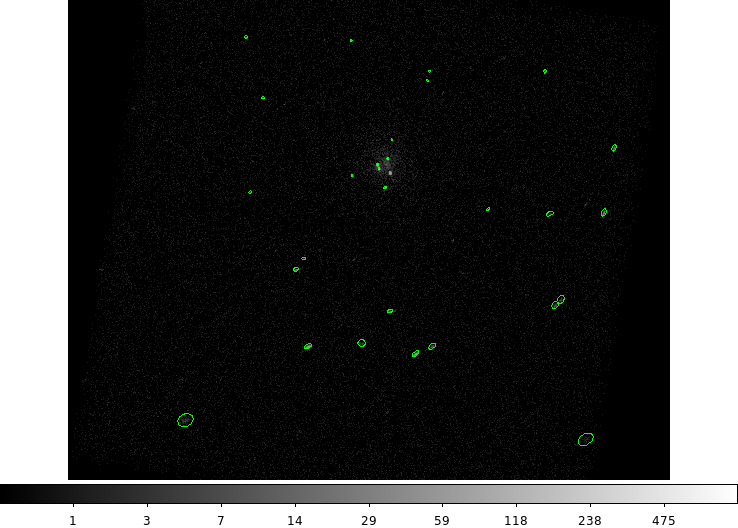

In [5]:
ds9 5794_broad_thresh.img -scale log \
  -block 2 \
  -region cell_src.fits \
  -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit

display < ds9_01.png

## Create Src Map


### Make all 1's

In [6]:
dmimgcalc 5794_broad_thresh.img none ones.fits op="imgout=1.0+img1-img1" clob+

In [7]:
dmstat ones.fits cen-

ones.fits
    min:	1 	      @:	( 3468 3203 )
    max:	1 	      @:	( 3468 3203 )
   mean:	1 
  sigma:	0 
    sum:	1455640 
   good:	1455640 
   null:	0 


### Filter and scale by source regions

In [8]:
max_srcs=`pget roi num_srcs`
echo $max_srcs

29


In [9]:
n=1
while test $n -le ${max_srcs}
do
  n0=`printf "%04d" $n`
  dmimgcalc "ones.fits[sky=region(5794_${n0}.reg)][opt full,update=no]" \
    none out_${n0}.img op=imgout="img1*((float)${n})" clob+
  n=`expr $n + 1`

done


In [10]:
dmimgfilt "out_*.img" src.map function=max mask="point(0,0)" clob+

[1] 7418
[1]+  Done                    ds9 src.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut -scale limits -1.5 $max_srcs -zoom 0.5 -saveimage png ds9_02.png


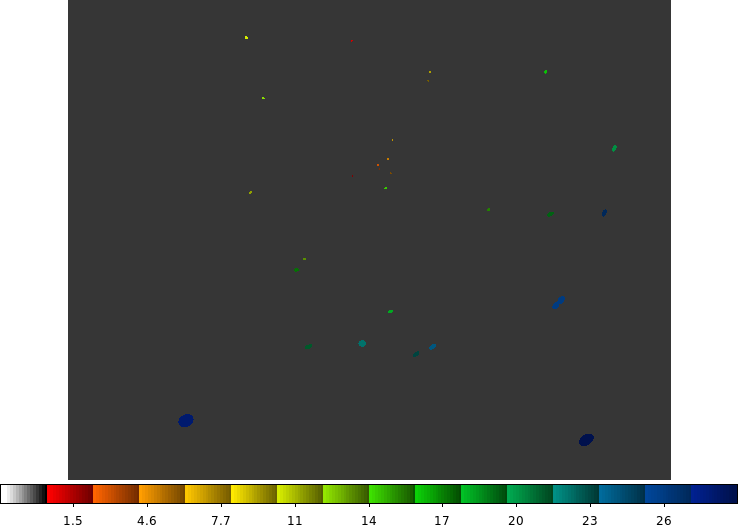

In [11]:
ds9 src.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -scale limits -1.5 $max_srcs \
  -zoom 0.5 \
  -saveimage png ds9_02.png &
sleep 10
xpaset -p ds9 quit

display < ds9_02.png

In [12]:
dmsort cell_src.fits cell_src_sort.fits snr clob+

## Complex example

In [13]:
vtpdetect 5794_broad_thresh.img 5794_broad_thresh.expmap vtp_out.fits \
  scale=0.7 mode=h clob+

In [14]:
dmlist vtp_out.fits blocks

 
--------------------------------------------------------------------------------
Dataset: vtp_out.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: SRCLIST                        Table        24 cols x 34       rows
Block    3: SRC_REGION                     Table         5 cols x 50       rows


[1] 7496
[1]+  Done                    ds9 5794_broad_thresh.img -block 2 -region "vtp_out.fits[src_region]" -scale log -saveimage png ds9_03.png


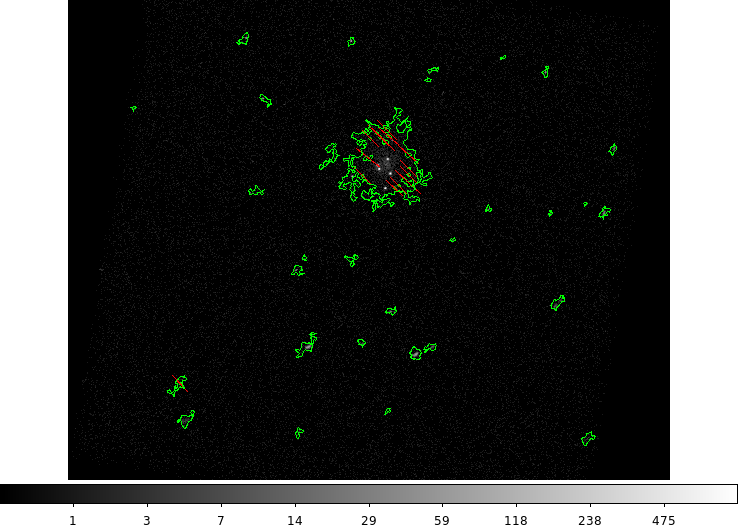

In [15]:
ds9 5794_broad_thresh.img -block 2 \
  -region "vtp_out.fits[src_region]" \
  -scale log \
  -saveimage png ds9_03.png &
sleep 10
xpaset -p ds9 quit

display < ds9_03.png 

In [16]:
dmstat vtp_out.fits"[src_region][cols component]" verbose=0
max_srcs=`pget dmstat out_max`
echo $max_srcs

34


In [17]:
n=1
while test $n -le ${max_srcs}
do
  n0=`printf "%04d" $n`
    dmimgcalc "ones.fits[sky=region(vtp_out.fits[src_region][component=${n}])][opt full,update=no]" \
        none v${n0}.img op="imgout=img1*${n}" clob+
  n=`expr $n + 1`

done


In [18]:
dmimgfilt "v*.img" vtp.map function=max mask="point(0,0)" clob+

[1] 8313
[1]+  Done                    ds9 vtp.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut -scale limits -1.9 $max_srcs -zoom 0.5 -saveimage png ds9_04.png


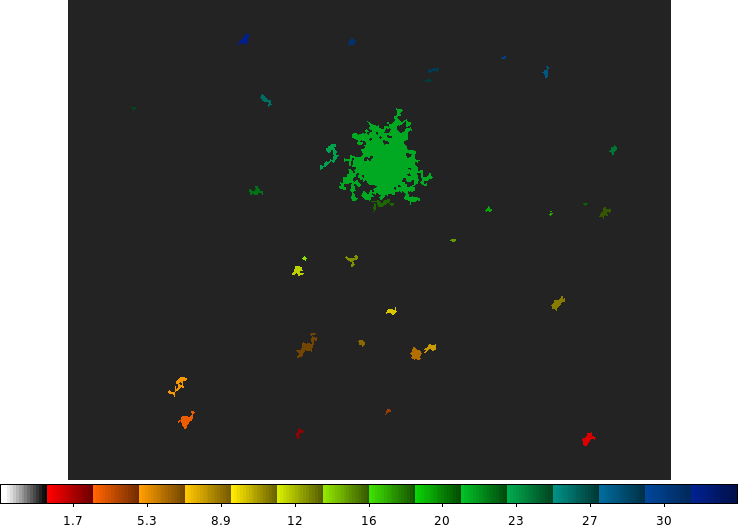

In [19]:
ds9 vtp.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -scale limits -1.9 $max_srcs \
  -zoom 0.5 \
  -saveimage png ds9_04.png &
sleep 10
xpaset -p ds9 quit

display < ds9_04.png

## Summary

### dmimgpick

In [20]:
dmimgpick acisf05794_repro_evt2.fits src.map mapped_evts.fits method=closest clob+

In [21]:
dmlist mapped_evts.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block EVENTS
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range            Null
   1   time                 s            Real8          221007858.4157499969:221090410.8944700062 -          S/C TT corresponding to mid-exposure
   2   expno                             Int4           0:2147483647         -          Exposure number of CCD frame containing event
   3   ccd_id                            Int2           0:9                  -          CCD reporting event
   4   node_id                           Int2           0:3                  -          CCD serial readout amplifier node
   5   chip(chipx,chipy)    pixel        Int2           1:1024               -          Chip coords
   6   tdet(tdetx,tdety)    pixel        Int2           1:8192               9999       ACIS tiled detector coordi

### Threhold to make mask

In [22]:
dmimgthresh vtp.map - cut=19:19 value=0 | dmimghull - 19.reg clob+

[1] 8455
[1]+  Done                    ds9 5794_broad_thresh.img -scale log -block 2 -region 19.reg -saveimage png ds9_05.png


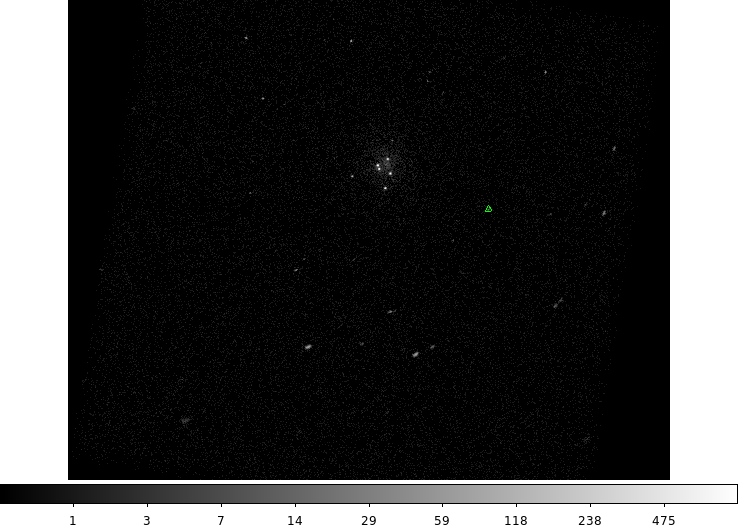

In [23]:
ds9 5794_broad_thresh.img -scale log \
  -block 2 \
  -region 19.reg \
  -saveimage png ds9_05.png &
sleep 10
xpaset -p ds9 quit

display < ds9_05.png

### fill

In [24]:
dmmaskfill 'cell_src.fits[cols component,snr]' 'src.map[opt type=i4]' SNR.map clob+

In [25]:
# Replace NaN with 0
dmimgthresh SNR.map - cut=INDEF value=0 | \
dmimgfilt - SNR_diolate.map max "box(0,0,3,3)" numiter=5 mode=h clob+

[1] 8604
[1]+  Done                    ds9 SNR_diolate.map -scale linear -zoom 0.5 -cmap load $ASCDS_CONTRIB/data/16_ramps.lut -saveimage png ds9_06.png


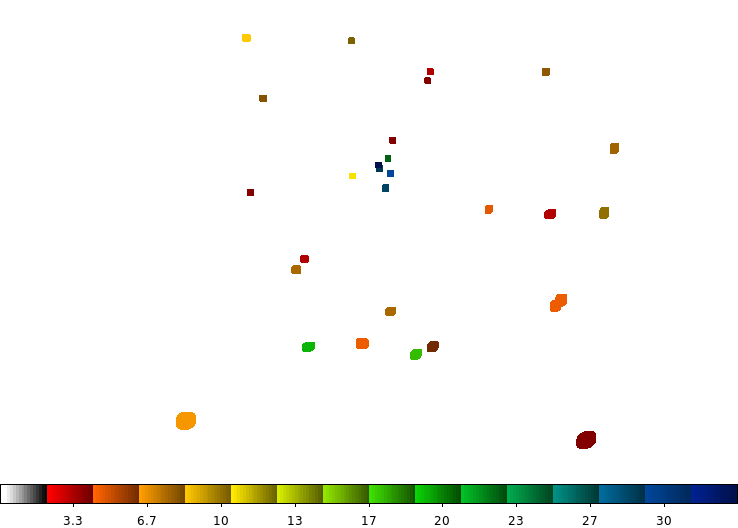

In [26]:

ds9 SNR_diolate.map -scale linear \
  -zoom 0.5 \
  -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -saveimage png ds9_06.png &
sleep 10
xpaset -p ds9 quit

display < ds9_06.png

# Cleanup

In [27]:
/bin/rm -rf 5794
/bin/rm -f acisf* pcadf* 
/bin/rm -f out_????.img v????.img 